---

# **Recherches sur l'encodage d'images**  

## **Objectif**  
Comprendre comment encoder les images afin qu’elles soient compatibles avec l’encodage de la requête textuelle, notamment dans le cadre d’une recherche d’images par similarité.  

## **1. Prétraitement de l’image**  
### **Redimensionnement et recadrage**  
L’image doit être adaptée aux dimensions attendues par le modèle (souvent 224×224 pixels, selon l’architecture). On peut appliquer un recadrage central ou un recadrage basé sur la détection de l’objet d’intérêt pour préserver les éléments essentiels.  

### **Normalisation**  
Les valeurs des pixels sont mises à l’échelle (généralement en les divisant par 255 pour obtenir une plage de 0 à 1). Une normalisation supplémentaire est ensuite appliquée avec des moyennes et écarts-types spécifiques (par exemple, [0.485, 0.456, 0.406] pour la moyenne et [0.229, 0.224, 0.225] pour l’écart-type dans les modèles entraînés sur ImageNet).  

## **2. Conversion en tenseurs**  
### **Transformation en format exploitable**  
Une fois prétraitée, l’image est convertie en tenseur. PyTorch, par exemple, propose `transforms.ToTensor()`, qui transforme l’image en un tenseur de la forme `[channels, height, width]`.  

### **Restructuration pour le batch**  
Pour traiter plusieurs images simultanément, une dimension supplémentaire est ajoutée, donnant une forme `[batch_size, channels, height, width]`.  

## **3. Passage dans l’encodeur d’images**  
### **Utilisation d’un encodeur pré-entraîné**  
L’image est ensuite passée dans un modèle d’encodage d’images pré-entraîné (comme l’encodeur de CLIP), qui la convertit en une représentation vectorielle (embedding) capturant ses caractéristiques essentielles.  

### **Mode évaluation**  
Pour garantir une inférence stable, le modèle doit être mis en mode évaluation (`model.eval()` en PyTorch), ce qui désactive des mécanismes comme le dropout et fige les poids.  

## **4. Alignement des espaces d’encodage**  
### **Entraînement multi-modal**  
L’encodeur a été entraîné sur des données associant images et textes via une perte contrastive. Cela permet d’aligner les embeddings d’images et de textes dans un même espace vectoriel.  

### **Comparaison des représentations**  
Une fois encodées dans le même espace, l’image et la requête textuelle peuvent être comparées grâce à des métriques comme la similarité cosinus ou le produit scalaire. Cela garantit une correspondance cohérente entre les deux modalités, facilitant des tâches comme la recherche d’images en zero-shot.  

---


In [7]:
import torch
import clip
from PIL import Image
import requests
from torchvision import transforms
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import numpy as np

# Loader the CLIP model and the preprocessing function
device = "cuda" if torch.cuda.is_available() else "cpu"
# Use a smaller model to reduce memory usage
model, preprocess = clip.load("ViT-B/32", device=device)

# Load an image from a URL and resize it to save memory
image_url = "https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
image = image.resize((224, 224))  # Resize the image to 512x512 to save memory

# Preprocess the image using the CLIP preprocessing function
image_tensor = preprocess(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Encode the image
with torch.no_grad():
    image_embedding = model.encode_image(image_tensor)

# Encode a text query 
text = clip.tokenize(["an orange cat"]).to(device) # Tokenize the text query
with torch.no_grad():
    text_embedding = model.encode_text(text) # Encode the text query

#Print of the mean and variance of the image and text embedding before normalization
print("\nImage embedding before normalization:", image_embedding.mean().item(), image_embedding.std().item()) # Print mean and std of image embedding
print("Text embedding before normalization:", text_embedding.mean().item(), text_embedding.std().item()) # Print mean and std of text embedding

# Normalize the image and text embeddings
normalize_image_embedding = image_embedding / image_embedding.norm(dim=-1, keepdim=True) # Normaliser l'embedding de l'image
normalize_text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True) # Normaliser l'embedding du texte

# Calcul of cosine similarity between the image and text embeddings
'''Cosine similarity is the dot product of the normalized embeddings
The result is a value between -1 and 1, where 1 means they are identical and -1 means they are completely different.
The closer to 1, the more similar they are. ''' 
similarity = (normalize_image_embedding @ normalize_text_embedding.T).item() # Scalar product of the normalized embeddings

# Print the results
print(f"\nSimilarité entre l'image et la requête textuelle : {similarity:.5f}")

print("\nImage embedding stats:", normalize_image_embedding.mean().item(), normalize_image_embedding.std().item())
print("Text embedding stats:", normalize_text_embedding.mean().item(), normalize_text_embedding.std().item())



Image embedding before normalization: -0.025199521332979202 0.47187912464141846
Text embedding before normalization: 0.013042120262980461 0.3861854076385498

Similarité entre l'image et la requête textuelle : 0.28320

Image embedding stats: -0.002359019359573722 0.04417433217167854
Text embedding stats: 0.0014931167243048549 0.04421214014291763


c:\Users\titou\anaconda3\envs\mon_environnement\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


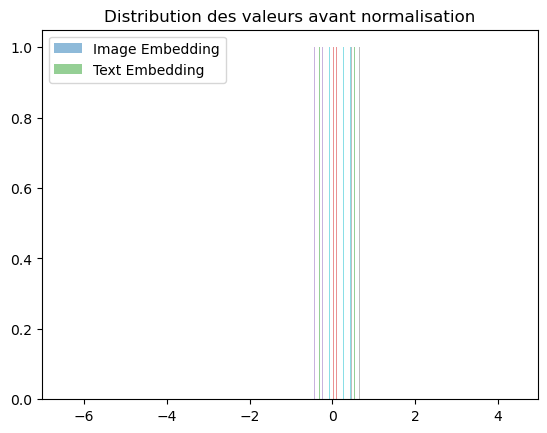

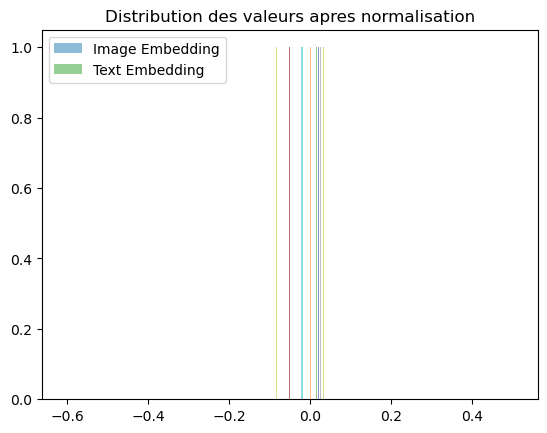

In [4]:
plt.hist(image_embedding.cpu().numpy(), bins=50, alpha=0.5, label="Image Embedding")
plt.hist(text_embedding.cpu().numpy(), bins=50, alpha=0.5, label="Text Embedding")
plt.legend()
plt.title("Distribution des valeurs avant normalisation")
plt.show()

# Affichage après normalisation

plt.hist(normalize_image_embedding.cpu().numpy(), bins=50, alpha=0.5, label="Image Embedding")
plt.hist(normalize_text_embedding.cpu().numpy(), bins=50, alpha=0.5, label="Text Embedding")
plt.legend()
plt.title("Distribution des valeurs apres normalisation")
plt.show()

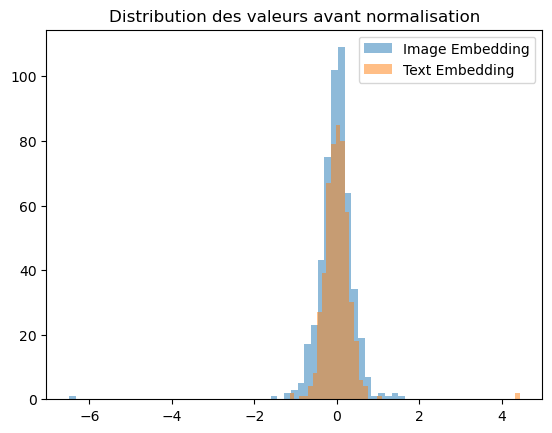

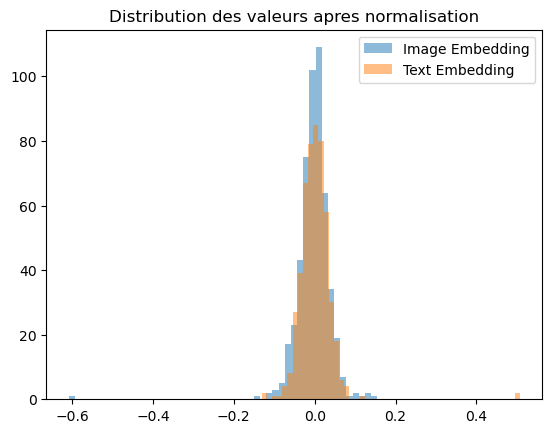

In [ ]:
# Affichage avant normalisation flattened
plt.hist(image_embedding.cpu().numpy().flatten(), bins=50, alpha=0.5, label="Image Embedding")
plt.hist(text_embedding.cpu().numpy().flatten(), bins=50, alpha=0.5, label="Text Embedding")
plt.legend()
plt.title("Distribution des valeurs avant normalisation")
plt.show()

# Affichage après normalisation flattened

plt.hist(normalize_image_embedding.cpu().numpy().flatten(), bins=50, alpha=0.5, label="Image Embedding")
plt.hist(normalize_text_embedding.cpu().numpy().flatten(), bins=50, alpha=0.5, label="Text Embedding")
plt.legend()
plt.title("Distribution des valeurs apres normalisation")
plt.show()

In [ ]:
import torch
import clip
from PIL import Image
import requests
from torchvision import transforms
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import numpy as np
#Torch set to deterministic mode
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loader the CLIP model and the preprocessing function
device = "cuda" if torch.cuda.is_available() else "cpu"
# Use a smaller model to reduce memory usage
model, preprocess = clip.load("ViT-B/32", device=device)

# Load an image from a URL and resize it to save memory
image_url = "https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
image = image.resize((224, 224))  # Resize the image to 512x512 to save memory

# Preprocess the image using the CLIP preprocessing function
image_tensor = preprocess(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Encode the image
with torch.no_grad():
    image_embedding = model.encode_image(image_tensor)

# Encode a text query 
text1 = clip.tokenize(["cat"]).to(device) # Tokenize the text query
with torch.no_grad():
    text_embedding1 = model.encode_text(text) # Encode the text query

text2 = clip.tokenize(["cat"]).to(device) # Tokenize the text query
with torch.no_grad():
    text_embedding2 = model.encode_text(text2) # Encode the text query

# Normalize the image and text embeddings
normalize_image_embedding = image_embedding / image_embedding.norm(dim=-1, keepdim=True) # Normaliser l'embedding de l'image
normalize_text_embedding1 = text_embedding1 / text_embedding1.norm(dim=-1, keepdim=True) # Normaliser l'embedding du texte 1
normalize_text_embedding2 = text_embedding2 / text_embedding2.norm(dim=-1, keepdim=True) # Normaliser l'embedding du texte 2

# Calcul of cosine similarity between the image and text embeddings
'''Cosine similarity is the dot product of the normalized embeddings
The result is a value between -1 and 1, where 1 means they are identical and -1 means they are completely different.
The closer to 1, the more similar they are. ''' 
similarity = (normalize_image_embedding @ normalize_text_embedding.T).item() # Scalar product of the normalized embeddings
similarity1 = (normalize_text_embedding1 @ normalize_text_embedding2.T).item() # Scalar product of the normalized embeddings

# Print the embeddings 
#print("Text embedding:", normalize_text_embedding1)
#print("Text embedding:", normalize_text_embedding2)

# Print the results
print(f"\nSimilarité entre l'image et la requête textuelle : {similarity:.5f}")
print(f"\nSimilarité entre les deux requêtes textuelles : {similarity1}")

print("\nImage embedding stats:", normalize_image_embedding.mean().item(), normalize_image_embedding.std().item())
print("Text embedding stats:", normalize_text_embedding.mean().item(), normalize_text_embedding.std().item())


Similarité entre l'image et la requête textuelle : 0.28320

Similarité entre les deux requêtes textuelles : 0.806178867816925

Image embedding stats: -0.002359019359573722 0.04417433217167854
Text embedding stats: 0.0014931167243048549 0.04421214014291763


## TEST

### Test avec une autre fonction de similarité : Distance Euclidienne

In [2]:
import torch
import clip
from PIL import Image
import requests
from scipy.spatial.distance import cosine, euclidean

# Charger le modèle CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Charger et prétraiter l’image
image_url = "https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg"
image = Image.open(requests.get(image_url, stream=True).raw).resize((224, 224))
image_tensor = preprocess(image).unsqueeze(0).to(device)

# Encoder l’image
with torch.no_grad():
    image_embedding = model.encode_image(image_tensor)

# Encoder le texte
text = clip.tokenize(["an orange cat"]).to(device)
with torch.no_grad():
    text_embedding = model.encode_text(text)

# Normalisation
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)

# Similarité
similarity_cosine = (image_embedding @ text_embedding.T).item()
similarity_euclidean = euclidean(image_embedding.cpu().numpy().flatten(), text_embedding.cpu().numpy().flatten())

print(f"Similarité cosinus : {similarity_cosine:.5f}")
print(f"Distance Euclidienne : {similarity_euclidean:.5f}")


Similarité cosinus : 0.28320
Distance Euclidienne : 1.19733


### Test avec une réduction de dimensionnalité (PCA)

In [4]:
import torch
import clip
from PIL import Image
import requests
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Liste d’images et de textes
image_urls = [
    "https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Kittyply_edit1.jpg/800px-Kittyply_edit1.jpg"
]
texts = ["an orange cat", "a cute kitten"]

# Obtenir les embeddings d'images
image_embeddings = []
for url in image_urls:
    img = Image.open(requests.get(url, stream=True).raw).resize((224, 224))
    tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.encode_image(tensor)
        image_embeddings.append(emb.cpu().numpy().flatten())

# Obtenir les embeddings de texte
with torch.no_grad():
    text_tokens = clip.tokenize(texts).to(device)
    text_embeddings = model.encode_text(text_tokens).cpu().numpy()

# Appliquer PCA
all_embeddings = np.vstack(image_embeddings + list(text_embeddings))
# Set n_components to the minimum of n_samples and n_features
n_components = min(all_embeddings.shape[0], all_embeddings.shape[1])
pca = PCA(n_components=n_components)
pca.fit(all_embeddings)

# Réduire la première image et le premier texte
img_pca = pca.transform(image_embeddings[0].reshape(1, -1))
txt_pca = pca.transform(text_embeddings[0].reshape(1, -1))

# Normalisation
img_pca /= np.linalg.norm(img_pca)
txt_pca /= np.linalg.norm(txt_pca)

# Similarité cosinus
similarity_pca = 1 - cosine(img_pca.flatten(), txt_pca.flatten())
print(f"Similarité après PCA : {similarity_pca:.5f}")


Similarité après PCA : -0.74706


### Fine-tuning de la normalisation des embeddings :

In [6]:
import torch
import clip
from PIL import Image
import requests
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.spatial.distance import cosine

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Image et texte
image_url = "https://c8.alamy.com/compfr/gcarhp/de-couleur-turquoise-original-chambre-lambrissee-remplie-d-objets-divers-gcarhp.jpg"
image = Image.open(requests.get(image_url, stream=True).raw).resize((224, 224))
image_tensor = preprocess(image).unsqueeze(0).to(device)

with torch.no_grad():
    image_embedding = model.encode_image(image_tensor)
    text = clip.tokenize(["a cat"]).to(device)
    text_embedding = model.encode_text(text)

# Convertir en numpy
X = image_embedding.cpu().numpy()
Y = text_embedding.cpu().numpy()

# Appliquer la régression vectorielle
reg = LinearRegression()
reg.fit(X, Y)
image_adjusted = reg.predict(X)
text_adjusted = reg.predict(Y)

# Calcul de la similarité
similarity_adjusted = 1 - cosine(image_adjusted.flatten(), text_adjusted.flatten())
print(f"Similarité ajustée (via régression) : {similarity_adjusted:.5f}")


Similarité ajustée (via régression) : 1.00000


# Pourquoi on a ces valeurs ?

In [ ]:
# Pourquoi on a ces valeurs ?
# Est ce normal d'avoir ces valeurs ?
# Les particulié ont ils le meme probleme
# Doit on prétraité les valeurs ou juste rajouter un module de regression linéaire ?
# Est ce que la normalisation est utile ?

## Réponse :
# On a ces valeurs car les embeddings d'images et de texte sont dans des espaces de caractéristiques différents.
# Ces valeurs sont normales car les embeddings peuvent avoir des distributions différentes.
# Les particuliers peuvent rencontrer le même problème, surtout si les données d'entraînement sont biaisées.
# La régression linéaire peut aider, mais ce n’est pas suffisant si le problème est plus complexe (non-linéaire).
"""    Le prétraitement des données (nettoyage, augmentation, contextualisation du texte) est aussi crucial.
    Tu peux aussi considérer :

    Réduction de bruit

    Embedding fusionné

Modèle entraîné pour ton domaine""""
# L'ajout d'un module de régression linéaire peut être une solution efficace pour ajuster les similarités.
